In [ ]:
# Instala a biblioteca codecarbon
!pip install codecarbon

### Gera grafos aleatórios

Digite o número de nos: 100


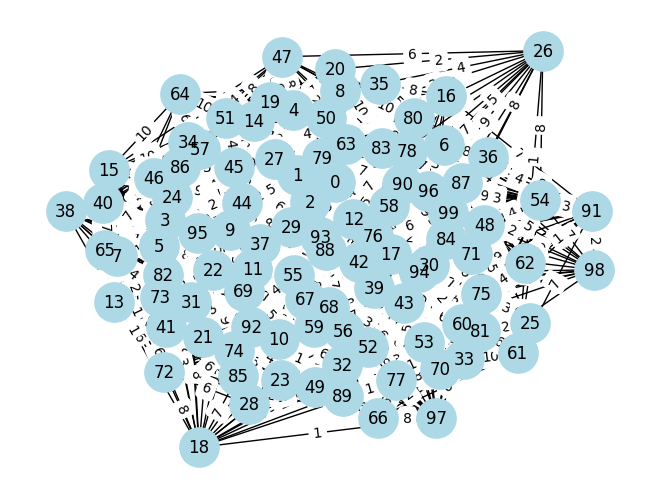

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker

# Recebe o número de nós do usuário
numero_nos = int(input("Digite o número de nos: "))

# Cria um grafo aleatório com 10 nós e probabilidade 0.3
G = nx.gnp_random_graph(numero_nos, p=0.3, seed=42)

# Filtra o componente gigante (maior subgrafo conectado)
if not nx.is_connected(G):
    G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Adiciona pesos (inteiros entre 1 e 10)
for u, v in G.edges():
    G[u][v]['weight'] = random.randint(1, 10)

# Visualização com pesos nas arestas
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.show()

### Cria os dataframe

In [58]:
import pandas as pd

# Definir índices (linhas) e colunas
linhas = [100, 500, 1000, 5000, 10000, 50000, 100000]
colunas = list(range(1, 16))  # 1 a 15

# Criar DataFrames com zeros do tipo float
df_dijkstra = pd.DataFrame(0.0, index=linhas, columns=colunas)
df_dijkstraMinHeap = pd.DataFrame(0.0, index=linhas, columns=colunas)
df_networkx = pd.DataFrame(0.0, index=linhas, columns=colunas)
df_O2dijkstra = pd.DataFrame(0.0, index=linhas, columns=colunas)
df_O2dijkstraMinHeap = pd.DataFrame(0.0, index=linhas, columns=colunas)
df_O2networkx = pd.DataFrame(0.0, index=linhas, columns=colunas)


### Algoritmo de Dijkstra

In [59]:
# O(V^2 + E) tempo | O(V) espaço - onde V é o número de vértices e E é o número de arestas no grafo de entrada
def dijkstrasAlgorithm(start, edges):
    """
    Implementa o algoritmo de Dijkstra para encontrar o caminho mais curto de um nó inicial para todos os outros nós em um grafo.

    Args:
        start (int): O índice do nó inicial.
        edges (list of list): Lista de adjacência representando o grafo. Cada índice corresponde a um vértice, e cada entrada é uma lista de pares [destino, peso].

    Returns:
        list: Uma lista das menores distâncias do nó inicial para cada nó. Se um nó não for alcançável, a distância será -1.
    """
    numberOfVertices = len(edges)

    # Inicializa as distâncias mínimas para todos os vértices como infinito,
    # exceto o vértice inicial, que é definido como 0.
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    # Mantém o controle dos nós visitados para evitar reprocessá-los.
    visited = set()

    # Continua processando os nós até que todos tenham sido visitados.
    while len(visited) != numberOfVertices:
        # Encontra o vértice com a menor distância conhecida que ainda não foi visitado.
        vertex, currentMinDistance = getVertexWithMinDistance(minDistances, visited)

        # Se a menor distância for infinito, todos os vértices restantes são inalcançáveis.
        if currentMinDistance == float("inf"):
            break

        # Marca o vértice atual como visitado.
        visited.add(vertex)

        # Itera por todos os vizinhos do vértice atual.
        for edge in edges[vertex]:
            destination, distanceToDestination = edge

            # Ignora o vizinho se ele já foi visitado.
            if destination in visited:
                continue

            # Calcula a nova distância potencial para o vizinho.
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            # Atualiza a menor distância para o vizinho se o novo caminho for mais curto.
            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance

    # Substitui quaisquer distâncias infinitas restantes por -1 para indicar nós inalcançáveis.
    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))

def getVertexWithMinDistance(distances, visited):
    """
    Função auxiliar para encontrar o vértice com a menor distância conhecida que ainda não foi visitado.

    Args:
        distances (list): Uma lista das menores distâncias conhecidas para cada vértice.
        visited (set): Um conjunto de vértices que já foram visitados.

    Returns:
        tuple: O índice do vértice com a menor distância e seu valor de distância.
    """
    currentMinDistance = float("inf")
    vertex = -1

    # Itera por todos os vértices para encontrar aquele com a menor distância.
    for vertexIdx, distance in enumerate(distances):
        # Ignora o vértice se ele já foi visitado.
        if vertexIdx in visited:
            continue

        # Atualiza a menor distância atual e o vértice se uma distância menor for encontrada.
        if distance <= currentMinDistance:
            vertex = vertexIdx
            currentMinDistance = distance

    return vertex, currentMinDistance

### Alogiritmo de Dijkstra com Min-Heap

In [60]:
class MinHeap:
    """
    Classe MinHeap: Implementa uma estrutura de dados MinHeap para gerenciar eficientemente vértices e suas distâncias
    em algoritmos como o de Dijkstra. Esta implementação mantém o controle da posição de cada vértice usando
    um mapa de vértices para buscas e atualizações em tempo constante.
    """
    def __init__(self, array):
        """
        Inicializa o MinHeap com um array de entrada de pares (vértice, distância).

        Args:
            array (list): Lista de tuplas onde cada tupla é (vértice, distância).
            A distância é tipicamente inicializada como infinito, exceto para o vértice inicial.

        Atributos:
            vertexMap (dict): Mapeia cada vértice para sua posição no heap para acesso rápido.
            heap (list): Lista que representa o heap binário como um array.
        """
        # Cria um mapa de vértices: Mapeia vértices para seus índices no heap.
        self.vertexMap = {idx: idx for idx in range(len(array))}

        # Constrói o heap a partir do array de entrada para satisfazer a propriedade do heap.
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        """
        Verifica se o heap está vazio.

        Returns:
            bool: True se o heap estiver vazio, False caso contrário.
        """
        return len(self.heap) == 0

    def buildHeap(self, array):
        """
        Constrói o heap a partir de um array de entrada em tempo O(n).

        Args:
            array (list): Lista de pares (vértice, distância).

        Returns:
            list: O array de entrada transformado em um MinHeap válido.
        """
        # Começa do primeiro nó pai e realiza o sift down em cada nó.
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        """
        Restaura a propriedade do heap "descendo" um nó para sua posição correta.

        Args:
            currentIdx (int): Índice do nó a ser descido.
            endIdx (int): Último índice no heap.
            heap (list): O array do heap.

        Complexidade:
            Tempo: O(log(n))
            Espaço: O(1)
        """
        childOneIdx = currentIdx * 2 + 1  # Índice do primeiro filho
        while childOneIdx <= endIdx:
            # Determina o índice do segundo filho
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1

            # Escolhe o menor filho para manter a propriedade do min-heap
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx

            # Troca se o filho for menor que o nó atual
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap  # Move para a posição trocada
                childOneIdx = currentIdx * 2 + 1  # Atualiza o índice do primeiro filho
            else:
                return

    def siftUp(self, currentIdx, heap):
        """
        Restaura a propriedade do heap "subindo" um nó para sua posição correta.

        Args:
            currentIdx (int): Índice do nó a ser subido.
            heap (list): O array do heap.

        Complexidade:
            Tempo: O(log(n))
            Espaço: O(1)
        """
        parentIdx = (currentIdx - 1) // 2  # Calcula o índice do pai
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)  # Troca com o pai
            currentIdx = parentIdx  # Move para a posição do pai
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        """
        Remove e retorna o menor elemento (raiz) no heap.

        Returns:
            tuple: O par (vértice, distância) com a menor distância.

        Complexidade:
            Tempo: O(log(n))
            Espaço: O(1)
        """
        if self.isEmpty():
            return None

        # Troca a raiz com o último elemento e o remove
        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)  # Remove o vértice do mapa

        # Restaura a propriedade do heap
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        """
        Troca dois nós no heap e atualiza suas posições no vertexMap.

        Args:
            i (int): Índice do primeiro nó.
            j (int): Índice do segundo nó.
            heap (list): O array do heap.
        """
        self.vertexMap[heap[i][0]] = j  # Atualiza o vertexMap para heap[i]
        self.vertexMap[heap[j][0]] = i  # Atualiza o vertexMap para heap[j]
        heap[i], heap[j] = heap[j], heap[i]  # Troca os nós no heap

    def update(self, vertex, value):
        """
        Atualiza a distância de um dado vértice e restaura a propriedade do heap.

        Args:
            vertex (int): O vértice cuja distância será atualizada.
            value (int): O novo valor da distância.

        Complexidade:
            Tempo: O(log(n))
            Espaço: O(1)
        """
        # Atualiza o heap com o novo par (vértice, valor)
        self.heap[self.vertexMap[vertex]] = (vertex, value)
        # Restaura a propriedade do heap subindo o nó atualizado
        self.siftUp(self.vertexMap[vertex], self.heap)

In [61]:
# O((v + e) * log(v)) tempo | O(v) espaço — onde v é o número
# de vértices e e é o número de arestas no grafo de entrada
def dijkstrasAlgorithmMinHeap(start, edges):
    """
    Implementa o algoritmo de Dijkstra para encontrar os caminhos mais curtos de um vértice inicial para todos os outros vértices
    em um grafo ponderado. O grafo é representado usando uma lista de adjacência.

    Args:
        start (int): O índice do vértice inicial.
        edges (list of list): Uma lista de adjacência onde cada índice representa um vértice, e cada entrada é uma lista de pares [destino, peso].

    Returns:
        list: Uma lista de distâncias mínimas do vértice inicial para cada vértice no grafo.
        Se um vértice for inalcançável, sua distância será representada como -1.
    """
    # Passo 1: Inicializa o número de vértices no grafo
    numberOfVertices = len(edges)

    # Passo 2: Inicializa as distâncias mínimas com infinito
    # Define a distância do vértice inicial como 0
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    # Passo 3: Inicializa o MinHeap para rastrear os vértices e suas distâncias mais curtas atuais
    minDistancesHeap = MinHeap([(idx, float("inf")) for idx in range(numberOfVertices)])
    minDistancesHeap.update(start, 0)  # Atualiza a distância do vértice inicial para 0

    # Passo 4: Processa os vértices até que o heap esteja vazio
    while not minDistancesHeap.isEmpty():
        # Extrai o vértice com a menor distância conhecida
        vertex, currentMinDistance = minDistancesHeap.remove()

        # Se a distância atual for infinito, não existem mais vértices alcançáveis
        if currentMinDistance == float("inf"):
            break

        # Passo 5: Relaxamento - Atualiza as distâncias para todos os vértices vizinhos
        for edge in edges[vertex]:
            destination, distanceToDestination = edge  # Extrai o vizinho e o peso

            # Calcula a nova distância potencial do caminho
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            # Se o novo caminho for mais curto, atualiza a distância e o heap
            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance
                minDistancesHeap.update(destination, newPathDistance)

    # Passo 6: Converte as distâncias dos vértices inalcançáveis de infinito para -1
    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))

### Seleciona 5 nós aleatórios do grafo e retorna a lista de adjacencia

In [62]:
# Seleciona 5 nós aleatórios do grafo G
nos_aleatorios = random.sample(list(G.nodes), 5)

print("Nós aleatórios selecionados:", nos_aleatorios)

def lista_adjacencia(grafo):
    lista_adj = {}
    for no, vizinhos in grafo.adjacency():
        lista_adj[no] = []
        for vizinho, atributos in vizinhos.items():
            peso = atributos.get('weight', None)
            lista_adj[no].append((vizinho, peso))
    return lista_adj

# Retorna a lista de adjacencia do grafo
lista_adjacencia_pesos = lista_adjacencia(G)


Nós aleatórios selecionados: [34, 53, 84, 60, 94]


### Calcula o tempo e emissões de CO2 para o algoritmo de Dijkstra

In [63]:
import time

# Laço for para rodar os algoritimos
for i in range(1, 16):

  # Inicia o rastreador de emissões
  tracker = EmissionsTracker(output_dir=".", save_to_file=False, log_level="error")
  tracker.start()

  # Mede o tempo total do algotimo de Dijkstra
  start_time = time.time()

  result = dijkstrasAlgorithm(nos_aleatorios[i%5], lista_adjacencia_pesos)

  # Finaliza o cálculo de tempo e emissões
  end_time = time.time()
  elapsed = end_time - start_time
  emissions = tracker.stop()

  # Salvando os dados no dataframe
  df_dijkstra.loc[numero_nos, i] = elapsed
  df_O2dijkstra.loc[numero_nos, i] = emissions


### Calcula o tempo e emissões de CO2 para o algoritmo de DijkstraMinHeap

In [64]:
# Laço for para rodar os algoritimos
for i in range(1, 16):

  # Inicia o rastreador de emissões
  tracker = EmissionsTracker(output_dir=".", save_to_file=False, log_level="error")
  tracker.start()

  # Mede o tempo total do algotimo de Dijkstra
  start_time = time.time()

  result = dijkstrasAlgorithmMinHeap(nos_aleatorios[i%5], lista_adjacencia_pesos)

  # Finaliza o cálculo de tempo e emissões
  end_time = time.time()
  elapsed = end_time - start_time
  emissions = tracker.stop()

  # Salvando os dados no dataframe
  df_dijkstraMinHeap.loc[numero_nos, i] = elapsed
  df_O2dijkstraMinHeap.loc[numero_nos, i] = emissions

### Calcula o tempo e emissões de CO2 para a função Bellman Ford do networkx

In [65]:
# Laço for para rodar os algoritimos
for i in range(1, 16):

  # Inicia o rastreador de emissões
  tracker = EmissionsTracker(output_dir=".", save_to_file=False, log_level="error")
  tracker.start()

  # Mede o tempo total do algotimo de Dijkstra
  start_time = time.time()

  result = dijkstrasAlgorithmMinHeap(nos_aleatorios[i%5], lista_adjacencia_pesos)

  # Finaliza o cálculo de tempo e emissões
  end_time = time.time()
  elapsed = end_time - start_time
  emissions = tracker.stop()

  # Salvando os dados no dataframe
  df_dijkstraMinHeap.loc[numero_nos, i] = elapsed
  df_O2.loc[numero_nos, i] = emissions# Laço for para rodar os algoritimos
for i in range(1, 16):

  # Inicia o rastreador de emissões
  tracker = EmissionsTracker(output_dir=".", save_to_file=False, log_level="error")
  tracker.start()

  # Mede o tempo total do algotimo de Dijkstra
  start_time = time.time()

  result = nx.single_source_bellman_ford_path_length(G, source=nos_aleatorios[i%5])

  # Finaliza o cálculo de tempo e emissões
  end_time = time.time()
  elapsed = end_time - start_time
  emissions = tracker.stop()

  # Salvando os dados no dataframe
  df_networkx.loc[numero_nos, i] = elapsed
  df_O2networkx.loc[numero_nos, i] = emissions

### Escreve os dados de média e desvio padrão do algoritmo de dijsktra

In [84]:
#Cria o dataframe dos dados de média e desvio padrão do Algoritmo de Dijkstra
linhas = [100, 500, 1000, 5000, 10000, 50000, 100000]
colunas = ["Média", "Desvio Padrão", "Média O2", "Desvio Padrão O2"]

df_dijkstraDados = pd.DataFrame(0.0, index=linhas, columns=colunas)

# Calcula a média e desvio Padrão
df_dijkstraDados["Média"] = df_dijkstra.mean(axis=1)
df_dijkstraDados["Desvio Padrão"] = df_dijkstra.std(axis=1)
df_dijkstraDados["Média O2"] = df_O2dijkstra.mean(axis=1)
df_dijkstraDados["Desvio Padrão O2"] = df_O2dijkstra.std(axis=1)

# Salva o dataFrame em um arquivo .CSV
df_dijkstraDados.to_csv('Dijkstra.csv', sep=',', decimal='.', index=True)

### Escreve os dados de média e desvio padrão do algoritmo de dijsktra com Min-Heap

In [87]:
#Cria o dataframe dos dados de média e desvio padrão do Algoritmo de Dijkstra
linhas = [100, 500, 1000, 5000, 10000, 50000, 100000]
colunas = ["Média", "Desvio Padrão", "Média O2", "Desvio Padrão O2"]

df_dijkstraDadosMinHeap = pd.DataFrame(0.0, index=linhas, columns=colunas)

# Calcula a média e desvio Padrão
df_dijkstraDadosMinHeap["Média"] = df_dijkstraMinHeap.mean(axis=1)
df_dijkstraDadosMinHeap["Desvio Padrão"] = df_dijkstraMinHeap.std(axis=1)
df_dijkstraDadosMinHeap["Média O2"] = df_O2dijkstraMinHeap.mean(axis=1)
df_dijkstraDadosMinHeap["Desvio Padrão O2"] = df_O2dijkstraMinHeap.std(axis=1)

# Salva o dataFrame em um arquivo .CSV
df_dijkstraDadosMinHeap.to_csv('DijkstraMinHeap.csv', sep=',', decimal='.', index=True)

### Escreve os dados de média e desvio padrão da função Bellman Ford

In [96]:
#Cria o dataframe dos dados de média e desvio padrão do Algoritmo de Dijkstra
linhas = [100, 500, 1000, 5000, 10000, 50000, 100000]
colunas = ["Média", "Desvio Padrão", "Média O2", "Desvio Padrão O2"]

df_Dadosnetworkx = pd.DataFrame(0.0, index=linhas, columns=colunas)

# Calcula a média e desvio Padrão
df_Dadosnetworkx["Média"] = df_networkx.mean(axis=1)
df_Dadosnetworkx["Desvio Padrão"] = df_networkx.std(axis=1)
df_Dadosnetworkx["Média O2"] = df_O2networkx.mean(axis=1)
df_Dadosnetworkx["Desvio Padrão O2"] = df_O2networkx.std(axis=1)

# Salva o dataFrame em um arquivo .CSV
df_Dadosnetworkx.to_csv('NetworkxReference.csv', sep=',', decimal='.', index=True)

Gráfico de média e emissões de CO2 para o algoritmo de Dijkstra

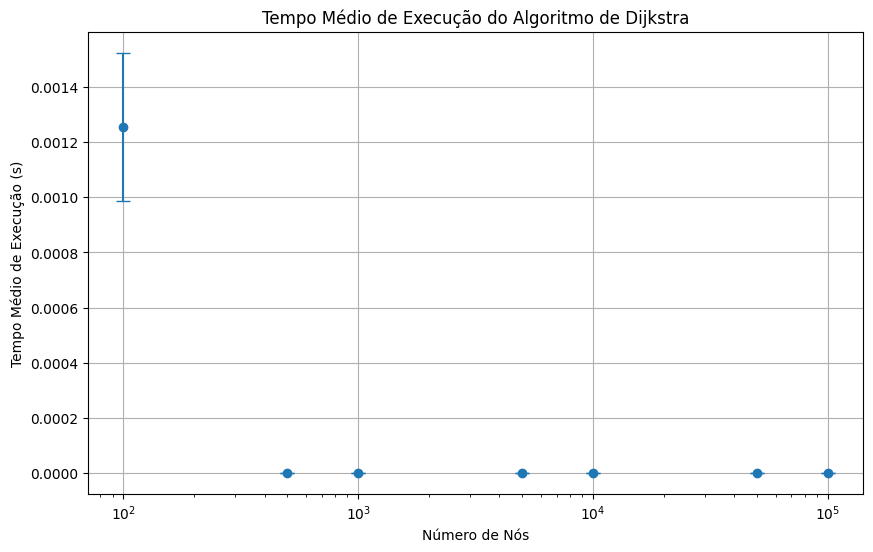

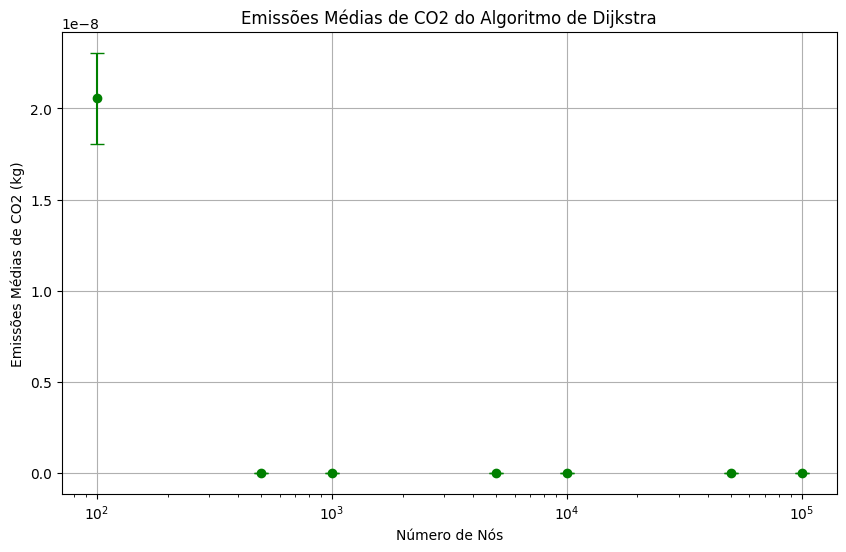

In [93]:
# Plotar o gráfico de tempo médio com desvio padrão
plt.figure(figsize=(10, 6))
# Revertendo para a escala logarítmica no eixo x e mantendo apenas os marcadores
plt.errorbar(df_dijkstraDados.index, df_dijkstraDados['Média'], yerr=df_dijkstraDados['Desvio Padrão'], fmt='o', capsize=5)
plt.xscale('log') # Usar escala logarítmica para o eixo x
plt.xlabel('Número de Nós')
plt.ylabel('Tempo Médio de Execução (s)')
plt.title('Tempo Médio de Execução do Algoritmo de Dijkstra')
plt.grid(True)
plt.show()

print()

# Plotar o gráfico de emissões médias de CO2 com desvio padrão
plt.figure(figsize=(10, 6))
# Revertendo para a escala logarítmica no eixo x e mantendo apenas os marcadores
plt.errorbar(df_dijkstraDados.index, df_dijkstraDados['Média O2'], yerr=df_dijkstraDados['Desvio Padrão O2'], fmt='o', capsize=5, color='green')
plt.xscale('log') # Usar escala logarítmica para o eixo x
plt.xlabel('Número de Nós')
plt.ylabel('Emissões Médias de CO2 (kg)')
plt.title('Emissões Médias de CO2 do Algoritmo de Dijkstra')
plt.grid(True)
plt.show()

Gráfico de média e emissões de CO2 para o algoritmo de Dijkstra com Min-Heap

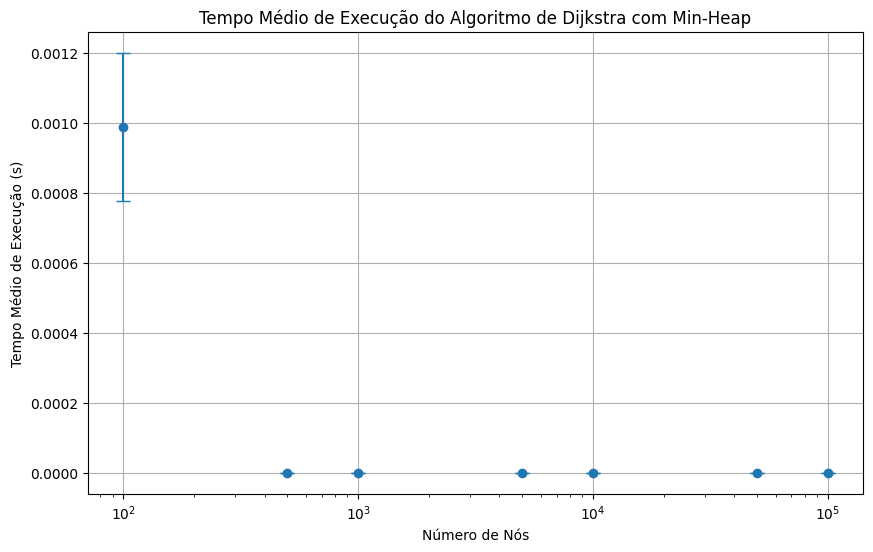

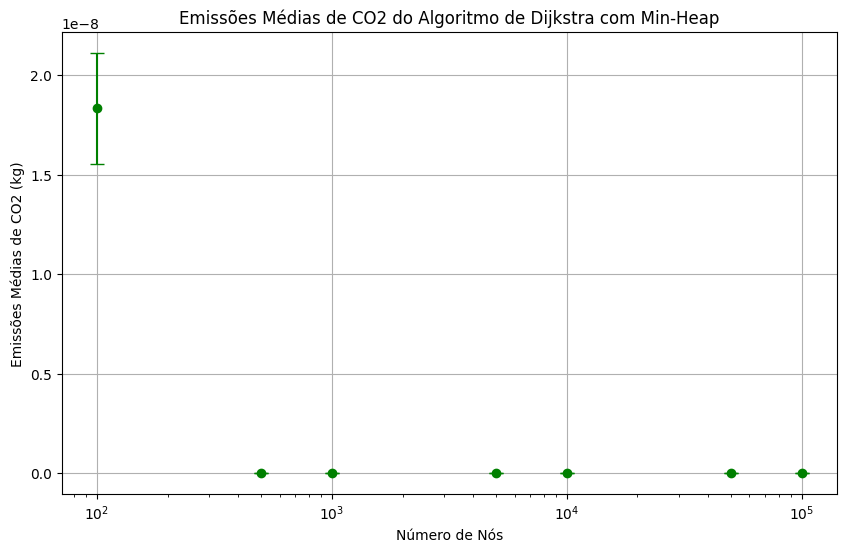

In [95]:
# Plotar o gráfico de tempo médio com desvio padrão para Dijkstra com Min-Heap
plt.figure(figsize=(10, 6))
plt.errorbar(df_dijkstraDadosMinHeap.index, df_dijkstraDadosMinHeap['Média'], yerr=df_dijkstraDadosMinHeap['Desvio Padrão'], fmt='o', capsize=5)
plt.xscale('log') # Usar escala logarítmica para o eixo x
plt.xlabel('Número de Nós')
plt.ylabel('Tempo Médio de Execução (s)')
plt.title('Tempo Médio de Execução do Algoritmo de Dijkstra com Min-Heap')
plt.grid(True)
plt.show()

print()

# Plotar o gráfico de emissões médias de CO2 com desvio padrão para Dijkstra com Min-Heap
plt.figure(figsize=(10, 6))
plt.errorbar(df_dijkstraDadosMinHeap.index, df_dijkstraDadosMinHeap['Média O2'], yerr=df_dijkstraDadosMinHeap['Desvio Padrão O2'], fmt='o', capsize=5, color='green')
plt.xscale('log') # Usar escala logarítmica para o eixo x
plt.xlabel('Número de Nós')
plt.ylabel('Emissões Médias de CO2 (kg)')
plt.title('Emissões Médias de CO2 do Algoritmo de Dijkstra com Min-Heap')
plt.grid(True)
plt.show()

### Gráfico de média e emissões de CO2 para a função Bellman Ford

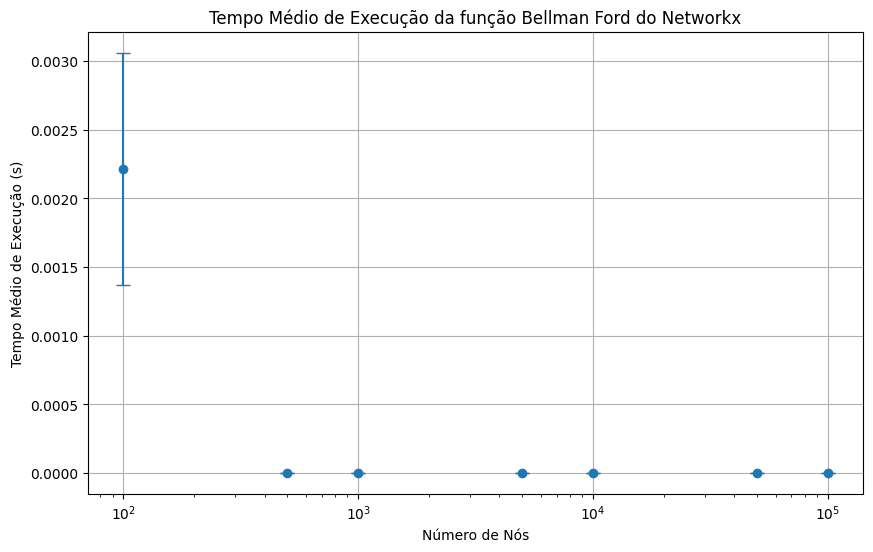

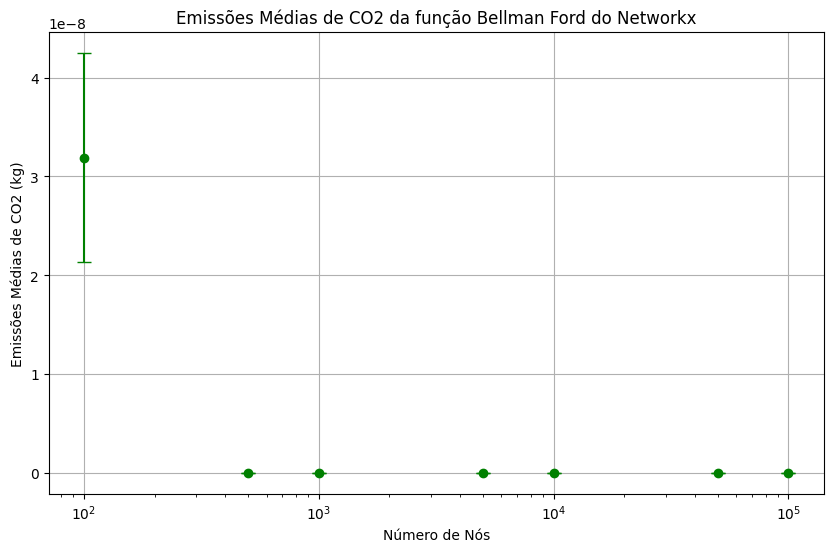

In [98]:
import matplotlib.pyplot as plt

# Plotar o gráfico de tempo médio com desvio padrão para Networkx Bellman Ford
plt.figure(figsize=(10, 6))
plt.errorbar(df_Dadosnetworkx.index, df_Dadosnetworkx['Média'], yerr=df_Dadosnetworkx['Desvio Padrão'], fmt='o', capsize=5)
plt.xscale('log') # Usar escala logarítmica para o eixo x
plt.xlabel('Número de Nós')
plt.ylabel('Tempo Médio de Execução (s)')
plt.title('Tempo Médio de Execução da função Bellman Ford do Networkx')
plt.grid(True)
plt.show()

print()

# Plotar o gráfico de emissões médias de CO2 com desvio padrão para Networkx Bellman Ford
plt.figure(figsize=(10, 6))
plt.errorbar(df_Dadosnetworkx.index, df_Dadosnetworkx['Média O2'], yerr=df_Dadosnetworkx['Desvio Padrão O2'], fmt='o', capsize=5, color='green')
plt.xscale('log') # Usar escala logarítmica para o eixo x
plt.xlabel('Número de Nós')
plt.ylabel('Emissões Médias de CO2 (kg)')
plt.title('Emissões Médias de CO2 da função Bellman Ford do Networkx')
plt.grid(True)
plt.show()